# Part 2 q 3

In [42]:
import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def sigmoid_derivative(output):
    return output * (1 - output)

def softmax(x):
    exps = [math.exp(i) for i in x]
    sum_exps = sum(exps)
    return [j / sum_exps for j in exps]

def cross_entropy(output, target):
    loss = -sum(target * math.log(max(output, 1e-15)) for output, target in zip(output, target))
    return loss

def forward_pass(inputs, weights_input_hidden, biases_hidden, weights_hidden_output, biases_output):
    hidden_layer_input = [sum(input_value * weight for input_value, weight in zip(inputs, weights)) + bias
                          for weights, bias in zip(weights_input_hidden, biases_hidden)]
    hidden_layer_output = [sigmoid(value) for value in hidden_layer_input]

    output_layer_input = [sum(hidden_output * weight for hidden_output, weight in zip(hidden_layer_output, weights)) + bias
                          for weights, bias in zip(weights_hidden_output, biases_output)]
    output_layer_output = softmax(output_layer_input)

    return hidden_layer_input, hidden_layer_output, output_layer_input, output_layer_output

def backward_pass(inputs, hidden_layer_input, hidden_layer_output, output_layer_input, outputs, target, weights_hidden_output):
    d_loss_d_outputs = [output - target_i for output, target_i in zip(outputs, target)]

    d_weights_hidden_output = [[d_loss * hidden_output for hidden_output in hidden_layer_output] for d_loss in d_loss_d_outputs]
    d_biases_output = d_loss_d_outputs.copy()

    d_loss_d_hidden = [sum(d_loss * weight for d_loss, weight in zip(d_loss_d_outputs, row)) for row in zip(*weights_hidden_output)]
    d_hidden_d_inputs = [sigmoid_derivative(value) for value in hidden_layer_input]

    d_weights_input_hidden = [[input_value * d_loss_d_hidden_output * d_hidden_input for input_value in inputs]
                              for d_loss_d_hidden_output, d_hidden_input in zip(d_loss_d_hidden, d_hidden_d_inputs)]
    d_biases_hidden = [d_loss_d_hidden_output * d_hidden_input for d_loss_d_hidden_output, d_hidden_input in zip(d_loss_d_hidden, d_hidden_d_inputs)]

    return d_weights_input_hidden, d_biases_hidden, d_weights_hidden_output, d_biases_output

weights_input_hidden = [[1, -1], [1, -1], [-1, 1]]
biases_hidden = [0, 0, 0]
weights_hidden_output = [[1, -1, -1], [1, -1, -1]]
biases_output = [0, 0]

inputs = [1, -1]
target = [1, 0]

hidden_layer_input, hidden_layer_output, output_layer_input, output_layer_output = forward_pass(inputs, weights_input_hidden, biases_hidden, weights_hidden_output, biases_output)
loss = cross_entropy(output_layer_output, target)
d_weights_input_hidden, d_biases_hidden, d_weights_hidden_output, d_biases_output = backward_pass(inputs, hidden_layer_input, hidden_layer_output, output_layer_input, output_layer_output, target, weights_hidden_output)

print("Forward pass output:", output_layer_output)
print("Loss:", loss)
print("Gradient w.r.t weights from input to hidden layer:", d_weights_input_hidden)
print("Gradient w.r.t biases in hidden layer:", d_biases_hidden)
print("Gradient w.r.t weights from hidden to output layer:", d_weights_hidden_output)
print("Gradient w.r.t biases in output layer:", d_biases_output)


Forward pass output: [0.5, 0.5]
Loss: 0.6931471805599453
Gradient w.r.t weights from input to hidden layer: [[-0.0, 0.0], [-0.0, 0.0], [-0.0, 0.0]]
Gradient w.r.t biases in hidden layer: [-0.0, -0.0, -0.0]
Gradient w.r.t weights from hidden to output layer: [[-0.44039853898894116, -0.44039853898894116, -0.05960146101105877], [0.44039853898894116, 0.44039853898894116, 0.05960146101105877]]
Gradient w.r.t biases in output layer: [-0.5, 0.5]


# Part 2 q 4

In [67]:
# -- assignment 1 --
import numpy as np
from urllib import request
import gzip
import pickle
import os

def load_synth(num_train=60_000, num_val=10_000, seed=0):
    """
    Load some very basic synthetic data that should be easy to classify. Two features, so that we can plot the
    decision boundary (which is an ellipse in the feature space).
    :param num_train: Number of training instances
    :param num_val: Number of test/validation instances
    :param num_features: Number of features per instance
    :return: Two tuples and an integer: (xtrain, ytrain), (xval, yval), num_cls. The first contains a matrix of training
     data with 2 features as a numpy floating point array, and the corresponding classification labels as a numpy
     integer array. The second contains the test/validation data in the same format. The last integer contains the
     number of classes (this is always 2 for this function).
    """
    np.random.seed(seed)

    THRESHOLD = 0.6
    quad = np.asarray([[1, -0.05], [1, .4]])

    ntotal = num_train + num_val

    x = np.random.randn(ntotal, 2)

    # compute the quadratic form
    q = np.einsum('bf, fk, bk -> b', x, quad, x)
    y = (q > THRESHOLD).astype(np.int)

    return (x[:num_train, :], y[:num_train]), (x[num_train:, :], y[num_train:]), 2

def load_mnist(final=False, flatten=True):
    """
    Load the MNIST data.
    :param final: If true, return the canonical test/train split. If false, split some validation data from the training
       data and keep the test data hidden.
    :param flatten: If true, each instance is flattened into a vector, so that the data is returns as a matrix with 768
        columns. If false, the data is returned as a 3-tensor preserving each image as a matrix.
    :return: Two tuples and an integer: (xtrain, ytrain), (xval, yval), num_cls. The first contains a matrix of training
     data and the corresponding classification labels as a numpy integer array. The second contains the test/validation
     data in the same format. The last integer contains the number of classes (this is always 2 for this function).
     """

    if not os.path.isfile('mnist.pkl'):
        init()

    xtrain, ytrain, xtest, ytest = load()
    xtl, xsl = xtrain.shape[0], xtest.shape[0]

    if flatten:
        xtrain = xtrain.reshape(xtl, -1)
        xtest  = xtest.reshape(xsl, -1)

    if not final: # return the flattened images
        return (xtrain[:-5000], ytrain[:-5000]), (xtrain[-5000:], ytrain[-5000:]), 10

    return (xtrain, ytrain), (xtest, ytest), 10

# Numpy-only MNIST loader. Courtesy of Hyeonseok Jung
# https://github.com/hsjeong5/MNIST-for-Numpy

filename = [
["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    download_mnist()
    save_mnist()

def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

In [72]:
import math
import random

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def sigmoid_derivative(output):
    return output * (1 - output)

def softmax(x):
    exps = [math.exp(i) for i in x]
    sum_exps = sum(exps)
    return [j / sum_exps for j in exps]

def forward_pass(inputs, weights_input_hidden, weights_output_hidden):
    hidden_layer_input = [sum(input_value * weight for input_value, weight in zip(inputs, weights)) for weights in weights_input_hidden]
    hidden_layer_output = [sigmoid(value) for value in hidden_layer_input]
    output_layer_input = [sum(hidden_value * weight for hidden_value, weight in zip(hidden_layer_output, weights)) for weights in weights_output_hidden]
    output_layer_output = softmax(output_layer_input)
    return hidden_layer_output, output_layer_output

def backward_pass(inputs, hidden_outputs, outputs, target, learning_rate, weights_input_hidden, weights_output_hidden):
    d_error_output = [output - target_i for output, target_i in zip(outputs, target)]
    d_weights_output_hidden = [[d_error_output[j] * hidden_output for hidden_output in hidden_outputs] for j in range(len(outputs))]
    for i in range(len(weights_output_hidden)):
        for j in range(len(hidden_outputs)):
            weights_output_hidden[i][j] -= learning_rate * d_weights_output_hidden[i][j]

    d_error_hidden = [0 for _ in range(len(hidden_outputs))]
    for i in range(len(hidden_outputs)):
        for j in range(len(outputs)):
            d_error_hidden[i] += weights_output_hidden[j][i] * d_error_output[j]
        d_error_hidden[i] *= sigmoid_derivative(hidden_outputs[i])

    d_weights_input_hidden = [[inputs[j] * d_error_hidden[i] for j in range(len(inputs))] for i in range(len(hidden_outputs))]
    for i in range(len(weights_input_hidden)):
        for j in range(len(inputs)):
            weights_input_hidden[i][j] -= learning_rate * d_weights_input_hidden[i][j]

    return weights_input_hidden, weights_output_hidden

def evaluate(x_val, y_val, weights_input_hidden, weights_output_hidden):
    correct_predictions = 0
    for x, y in zip(x_val, y_val):
        _, outputs = forward_pass(x, weights_input_hidden, weights_output_hidden)
        predicted_class = outputs.index(max(outputs))
        if predicted_class == y:
            correct_predictions += 1
    return correct_predictions / len(y_val)

def cross_entropy(output, target):
    loss = -sum(target * math.log(max(output, 1e-15)) for output, target in zip(output, target))
    return loss

train_losses = []

def train(x_train, y_train, x_val, y_val, learning_rate, epochs, weights_input_hidden, weights_output_hidden):
    for epoch in range(epochs):
        total_loss = 0
        for x, y in zip(x_train, y_train):
            target = [1 if y == cls else 0 for cls in range(2)]
            hidden_layer_output, output_layer_output = forward_pass(x, weights_input_hidden, weights_output_hidden)
            weights_input_hidden, weights_output_hidden = backward_pass(
                x, hidden_layer_output, output_layer_output, target, learning_rate,
                weights_input_hidden, weights_output_hidden
            )
            total_loss += cross_entropy(output_layer_output, target)

        tr_accuracy = evaluate(x_train, y_train, weights_input_hidden, weights_output_hidden)
        accuracy = evaluate(x_val, y_val, weights_input_hidden, weights_output_hidden)

        train_losses.append(total_loss / len(y_train))
        print(f'Epoch {epoch + 1}, Loss: {total_loss / len(y_train)}, Training Accuracy: {tr_accuracy}, Validation Accuracy: {accuracy}')

def normalize_data(data):
    min_val = min(min(row) for row in data)
    max_val = max(max(row) for row in data)
    return [[(2 * (x - min_val) / (max_val - min_val)) - 1 for x in row] for row in data]

(x_train, y_train), (x_val, y_val), num_cls = load_synth()

x_train = normalize_data(x_train)
x_val = normalize_data(x_val)


weights_input_hidden = [[random.gauss(-1, 1) for _ in range(2)] for _ in range(3)]
weights_output_hidden = [[random.gauss(-1, 1) for _ in range(3)] for _ in range(2)]

learning_rate = 0.01
epochs = 10

train(x_train, y_train, x_val, y_val, learning_rate, epochs, weights_input_hidden, weights_hidden_output)



<ipython-input-67-f79346ce6c31>:31: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (q > THRESHOLD).astype(np.int)


Epoch 1, Loss: 0.6732020224613916, Training Accuracy: 0.6611333333333334, Validation Accuracy: 0.3766
Epoch 2, Loss: 0.5182529658457795, Training Accuracy: 0.77585, Validation Accuracy: 0.3812
Epoch 3, Loss: 0.4571523311518034, Training Accuracy: 0.79365, Validation Accuracy: 0.3843
Epoch 4, Loss: 0.4483258130057622, Training Accuracy: 0.80065, Validation Accuracy: 0.3876
Epoch 5, Loss: 0.44520499931418106, Training Accuracy: 0.8047833333333333, Validation Accuracy: 0.3898
Epoch 6, Loss: 0.44391093996011877, Training Accuracy: 0.8072833333333334, Validation Accuracy: 0.392
Epoch 7, Loss: 0.44334886447712263, Training Accuracy: 0.8089166666666666, Validation Accuracy: 0.3925
Epoch 8, Loss: 0.4430482699758289, Training Accuracy: 0.8097666666666666, Validation Accuracy: 0.3939
Epoch 9, Loss: 0.44284262542542974, Training Accuracy: 0.8102833333333334, Validation Accuracy: 0.394
Epoch 10, Loss: 0.44267542090691564, Training Accuracy: 0.8103, Validation Accuracy: 0.3943


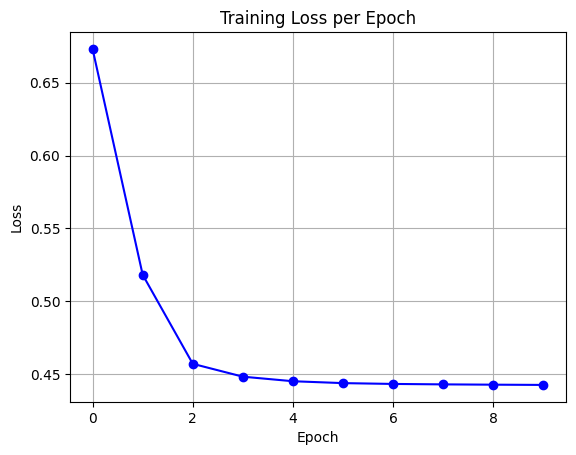

In [79]:
import matplotlib.pyplot as plt

plt.plot(train_losses, marker='o', linestyle='-', color='blue')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


# Part 3 q 5

In [6]:
import numpy as np

def sigmoid(x):
    clip_value = 20 # To prevent overflow in exp.
    x_clipped = np.clip(x, -clip_value, clip_value)
    return 1 / (1 + np.exp(-x_clipped))

def sigmoid_derivative(x):
    return x * (1 - x)

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def cross_entropy(a, y):
    m = y.shape[0]
    return -np.sum(y * np.log(a + 1e-15)) / m

def forward_pass(X, W1, b1, W2, b2):
    Z1 = np.matmul(X, W1) + b1
    A1 = sigmoid(Z1)
    Z2 = np.matmul(A1, W2) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def backward_pass(X, Y, A1, A2, W2):
    m = X.shape[0]
    dZ2 = A2 - Y
    dW2 = np.matmul(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m
    dA1 = np.matmul(dZ2, W2.T)
    dZ1 = dA1 * sigmoid_derivative(A1)
    dW1 = np.matmul(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m
    return dW1, db1, dW2, db2

def update_weights(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    return W1, b1, W2, b2

def one_hot_encode(y, num_classes=10):
    one_hot = np.zeros((len(y), num_classes))
    one_hot[np.arange(len(y)), y] = 1
    return one_hot

def predict(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_pass(X, W1, b1, W2, b2)
    predictions = np.argmax(A2, axis=1)
    return predictions

def get_accuracy(predictions, labels):
    return np.mean(predictions == labels)


In [7]:
def train_and_evaluate(X_train, y_train, X_val, y_val, W1, b1, W2, b2, epochs, learning_rate):
    training_losses = []
    training_accuracies = []
    validation_accuracies = []

    for epoch in range(epochs):
        Z1, A1, Z2, A2 = forward_pass(X_train, W1, b1, W2, b2)

        train_loss = cross_entropy(A2, y_train)
        training_losses.append(train_loss)

        train_predictions = predict(X_train, W1, b1, W2, b2)
        train_accuracy = get_accuracy(train_predictions, np.argmax(y_train, axis=1))
        training_accuracies.append(train_accuracy)

        dW1, db1, dW2, db2 = backward_pass(X_train, y_train, A1, A2, W2)
        W1, b1, W2, b2 = update_weights(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

        _, _, _, A2_val = forward_pass(X_val, W1, b1, W2, b2)
        val_predictions = predict(X_val, W1, b1, W2, b2)
        val_accuracy = get_accuracy(val_predictions, np.argmax(y_val, axis=1))
        validation_accuracies.append(val_accuracy)

        print(f"Epoch {epoch}, Training Loss: {train_loss}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")

    return W1, b1, W2, b2, training_losses, training_accuracies, validation_accuracies

In [8]:
(X_train, y_train), (X_test, y_test) , cval = load_mnist()

# Convert labels to one-hot encoding
y_train_one_hot = one_hot_encode(y_train)
y_test_one_hot = one_hot_encode(y_test)

y_train_one_hot = one_hot_encode(y_train)
y_test_one_hot = one_hot_encode(y_test)

# Xavier initialization
W1 = np.random.randn(784, 300) * np.sqrt(1. / 784)
b1 = np.zeros((1, 300))
W2 = np.random.randn(300, 10) * np.sqrt(1. / 300)
b2 = np.zeros((1, 10))

learning_rate = 0.1
epochs = 10

W1, b1, W2, b2, training_losses, training_accuracies, validation_accuracies = train_and_evaluate(
    X_train, y_train_one_hot, X_test, y_test_one_hot, W1, b1, W2, b2, epochs, learning_rate
)

Epoch 0, Training Loss: 2.452181974757658, Training Accuracy: 0.1125090909090909, Validation Accuracy: 0.268
Epoch 1, Training Loss: 2.0877339116532, Training Accuracy: 0.2777818181818182, Validation Accuracy: 0.4934
Epoch 2, Training Loss: 1.83656996788376, Training Accuracy: 0.4889090909090909, Validation Accuracy: 0.6124
Epoch 3, Training Loss: 1.6529259706452701, Training Accuracy: 0.5945272727272727, Validation Accuracy: 0.6772
Epoch 4, Training Loss: 1.5094824573810053, Training Accuracy: 0.6544363636363636, Validation Accuracy: 0.7244
Epoch 5, Training Loss: 1.393246111159818, Training Accuracy: 0.6942, Validation Accuracy: 0.7582
Epoch 6, Training Loss: 1.2964542627124203, Training Accuracy: 0.724, Validation Accuracy: 0.7822
Epoch 7, Training Loss: 1.2156604409768146, Training Accuracy: 0.7477454545454545, Validation Accuracy: 0.8064
Epoch 8, Training Loss: 1.146534594564981, Training Accuracy: 0.7652363636363636, Validation Accuracy: 0.8236
Epoch 9, Training Loss: 1.086401163

In [9]:
final_predictions = predict(X_test, W1, b1, W2, b2)
final_accuracy = get_accuracy(final_predictions, np.argmax(y_test_one_hot, axis=1))
print(f"Final Test Accuracy: {final_accuracy}")

Final Test Accuracy: 0.8384


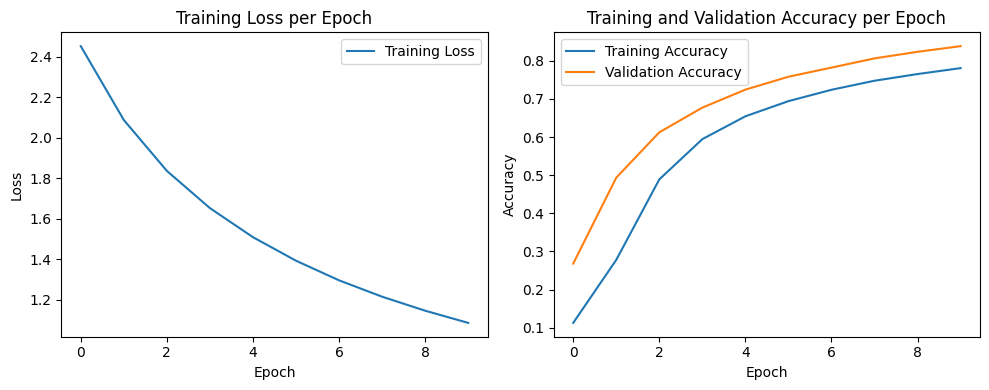

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Part 3 q 6

In [47]:
import numpy as np

def sigmoid(x):
    clip_value = 20
    x_clipped = np.clip(x, -clip_value, clip_value)
    return 1 / (1 + np.exp(-x_clipped))

def sigmoid_derivative(x):
    return x * (1 - x)

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def compute_loss(y_pred, y_true):
    m = y_true.shape[0]
    log_likelihood = -np.log(y_pred[range(m), y_true.argmax(axis=1)])
    loss = np.sum(log_likelihood) / m
    return loss

def forward_pass(X, W1, b1, W2, b2):
    Z1 = np.matmul(X, W1) + b1
    A1 = sigmoid(Z1)
    Z2 = np.matmul(A1, W2) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def backward_pass(X, Y, A1, A2, W2):
    m = X.shape[0]
    dZ2 = A2 - Y
    dW2 = np.matmul(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0) / m
    dA1 = np.matmul(dZ2, W2.T)
    dZ1 = dA1 * sigmoid_derivative(A1)
    dW1 = np.matmul(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0) / m
    return dW1, db1, dW2, db2

def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    return W1, b1, W2, b2

def one_hot_encode(y, num_classes=10):
    one_hot = np.zeros((len(y), num_classes))
    one_hot[np.arange(len(y)), y] = 1
    return one_hot

In [50]:
input_size = 784
hidden_size = 300
output_size = 10

W1 = np.random.randn(input_size, hidden_size) * np.sqrt(1. / input_size)
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1. / hidden_size)
b2 = np.zeros((1, output_size))

epochs = 10
learning_rate = 0.01
batch_size = 16

(X_train, y_train), (X_test, y_test), cval = load_mnist()

y_train_one_hot = one_hot_encode(y_train)
y_test_one_hot = one_hot_encode(y_test)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [51]:
for epoch in range(epochs):
    permutation = np.random.permutation(X_train.shape[0])
    X_train_shuffled = X_train[permutation]
    y_train_shuffled = y_train_one_hot[permutation]

    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train_shuffled[i:i + batch_size]
        Y_batch = y_train_shuffled[i:i + batch_size]

        Z1, A1, Z2, A2 = forward_pass(X_batch, W1, b1, W2, b2)
        loss = compute_loss(A2, Y_batch)
        dW1, db1, dW2, db2 = backward_pass(X_batch, Y_batch, A1, A2, W2)
        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

    _, _, _, A2_train = forward_pass(X_train, W1, b1, W2, b2)
    train_loss = compute_loss(A2_train, y_train_one_hot)
    train_accuracy = np.mean(np.argmax(A2_train, axis=1) == np.argmax(y_train_one_hot, axis=1))

    _, _, _, A2_val = forward_pass(X_test, W1, b1, W2, b2)
    val_loss = compute_loss(A2_val, y_test_one_hot)
    val_accuracy = np.mean(np.argmax(A2_val, axis=1) == np.argmax(y_test_one_hot, axis=1))

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{epochs} - Loss: {train_loss:.4f} - Accuracy: {train_accuracy:.4f} - Val Loss: {val_loss:.4f} - Val Accuracy:  {val_accuracy:.4f}")

Epoch 1/10 - Loss: 0.3352 - Accuracy: 0.9115 - Val Loss: 0.2710 - Val Accuracy:  0.9356
Epoch 2/10 - Loss: 0.2833 - Accuracy: 0.9228 - Val Loss: 0.2353 - Val Accuracy:  0.9350
Epoch 3/10 - Loss: 0.2679 - Accuracy: 0.9269 - Val Loss: 0.2188 - Val Accuracy:  0.9450
Epoch 4/10 - Loss: 0.2488 - Accuracy: 0.9313 - Val Loss: 0.2060 - Val Accuracy:  0.9446
Epoch 5/10 - Loss: 0.2337 - Accuracy: 0.9353 - Val Loss: 0.1984 - Val Accuracy:  0.9466
Epoch 6/10 - Loss: 0.2183 - Accuracy: 0.9397 - Val Loss: 0.1814 - Val Accuracy:  0.9524
Epoch 7/10 - Loss: 0.2231 - Accuracy: 0.9384 - Val Loss: 0.1906 - Val Accuracy:  0.9498
Epoch 8/10 - Loss: 0.2041 - Accuracy: 0.9441 - Val Loss: 0.1677 - Val Accuracy:  0.9570
Epoch 9/10 - Loss: 0.2003 - Accuracy: 0.9423 - Val Loss: 0.1709 - Val Accuracy:  0.9510
Epoch 10/10 - Loss: 0.2066 - Accuracy: 0.9390 - Val Loss: 0.1764 - Val Accuracy:  0.9518


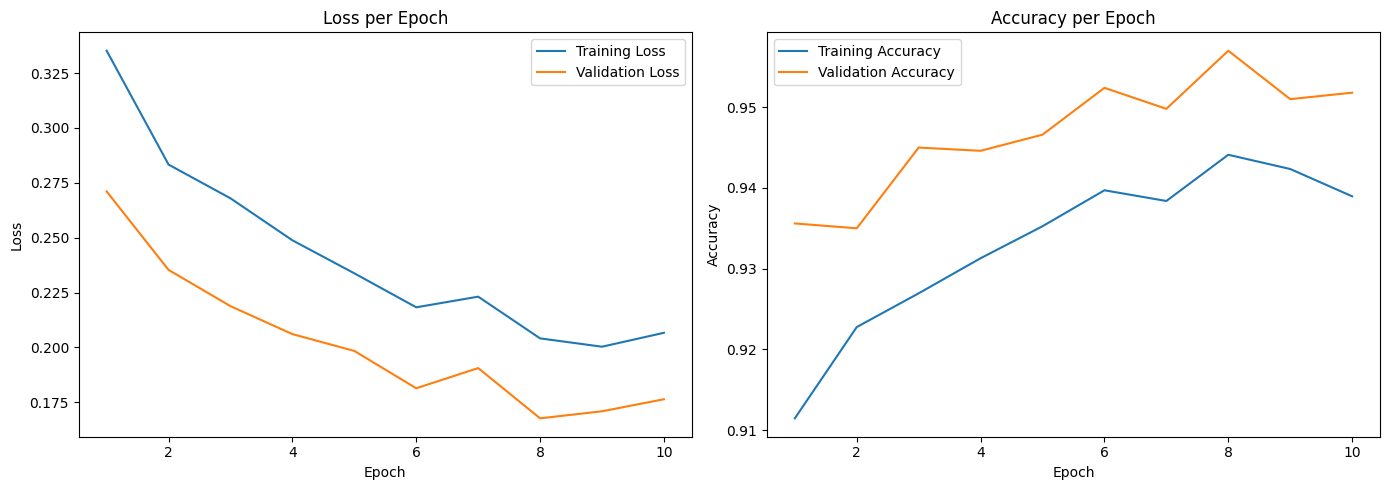

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Part 4 q 7

In [15]:
# -- assignment 1 --
import numpy as np
from urllib import request
import gzip
import pickle
import os

def load_synth(num_train=60_000, num_val=10_000, seed=0):
    """
    Load some very basic synthetic data that should be easy to classify. Two features, so that we can plot the
    decision boundary (which is an ellipse in the feature space).
    :param num_train: Number of training instances
    :param num_val: Number of test/validation instances
    :param num_features: Number of features per instance
    :return: Two tuples and an integer: (xtrain, ytrain), (xval, yval), num_cls. The first contains a matrix of training
     data with 2 features as a numpy floating point array, and the corresponding classification labels as a numpy
     integer array. The second contains the test/validation data in the same format. The last integer contains the
     number of classes (this is always 2 for this function).
    """
    np.random.seed(seed)

    THRESHOLD = 0.6
    quad = np.asarray([[1, -0.05], [1, .4]])

    ntotal = num_train + num_val

    x = np.random.randn(ntotal, 2)

    # compute the quadratic form
    q = np.einsum('bf, fk, bk -> b', x, quad, x)
    y = (q > THRESHOLD).astype(np.int)

    return (x[:num_train, :], y[:num_train]), (x[num_train:, :], y[num_train:]), 2

def load_mnist(final=False, flatten=True):
    """
    Load the MNIST data.
    :param final: If true, return the canonical test/train split. If false, split some validation data from the training
       data and keep the test data hidden.
    :param flatten: If true, each instance is flattened into a vector, so that the data is returns as a matrix with 768
        columns. If false, the data is returned as a 3-tensor preserving each image as a matrix.
    :return: Two tuples and an integer: (xtrain, ytrain), (xval, yval), num_cls. The first contains a matrix of training
     data and the corresponding classification labels as a numpy integer array. The second contains the test/validation
     data in the same format. The last integer contains the number of classes (this is always 2 for this function).
     """

    if not os.path.isfile('mnist.pkl'):
        init()

    xtrain, ytrain, xtest, ytest = load()
    xtl, xsl = xtrain.shape[0], xtest.shape[0]

    if flatten:
        xtrain = xtrain.reshape(xtl, -1)
        xtest  = xtest.reshape(xsl, -1)

    if not final: # return the flattened images
        return (xtrain[:-5000], ytrain[:-5000]), (xtrain[-5000:], ytrain[-5000:]), 10

    return (xtrain, ytrain), (xtest, ytest), 10

# Numpy-only MNIST loader. Courtesy of Hyeonseok Jung
# https://github.com/hsjeong5/MNIST-for-Numpy

filename = [
["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    download_mnist()
    save_mnist()

def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

In [16]:
import numpy as np

def sigmoid(x):
    clip_value = 20
    x_clipped = np.clip(x, -clip_value, clip_value)
    return 1 / (1 + np.exp(-x_clipped))

def sigmoid_derivative(x):
    return x * (1 - x)

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def compute_loss(y_pred, y_true):
    m = y_true.shape[0]
    log_likelihood = -np.log(y_pred[range(m), y_true.argmax(axis=1)])
    loss = np.sum(log_likelihood) / m
    return loss

def forward_pass(X, W1, b1, W2, b2):
    Z1 = np.matmul(X, W1) + b1
    A1 = sigmoid(Z1)
    Z2 = np.matmul(A1, W2) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def backward_pass(X, Y, A1, A2, W2):
    m = X.shape[0]
    dZ2 = A2 - Y
    dW2 = np.matmul(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0) / m
    dA1 = np.matmul(dZ2, W2.T)
    dZ1 = dA1 * sigmoid_derivative(A1)
    dW1 = np.matmul(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0) / m
    return dW1, db1, dW2, db2

def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    return W1, b1, W2, b2

def one_hot_encode(y, num_classes=10):
    one_hot = np.zeros((len(y), num_classes))
    one_hot[np.arange(len(y)), y] = 1
    return one_hot

In [17]:
input_size = 784
hidden_size = 300
output_size = 10

W1 = np.random.randn(input_size, hidden_size) * np.sqrt(1. / input_size)
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1. / hidden_size)
b2 = np.zeros((1, output_size))

epochs = 5
learning_rate = 0.01
batch_size = 16

(X_train, y_train), (X_test, y_test) , cval = load_mnist()

y_train_one_hot = one_hot_encode(y_train)
y_test_one_hot = one_hot_encode(y_test)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
batch_train_losses = []

In [18]:
for epoch in range(epochs):
    permutation = np.random.permutation(X_train.shape[0])
    X_train_shuffled = X_train[permutation]
    y_train_shuffled = y_train_one_hot[permutation]

    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train_shuffled[i:i + batch_size]
        Y_batch = y_train_shuffled[i:i + batch_size]

        Z1, A1, Z2, A2 = forward_pass(X_batch, W1, b1, W2, b2)
        loss = compute_loss(A2, Y_batch)
        batch_train_losses.append(loss)
        dW1, db1, dW2, db2 = backward_pass(X_batch, Y_batch, A1, A2, W2)
        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

    _, _, _, A2_train = forward_pass(X_train, W1, b1, W2, b2)
    train_loss = compute_loss(A2_train, y_train_one_hot)
    train_accuracy = np.mean(np.argmax(A2_train, axis=1) == np.argmax(y_train_one_hot, axis=1))

    _, _, _, A2_val = forward_pass(X_test, W1, b1, W2, b2)
    val_loss = compute_loss(A2_val, y_test_one_hot)
    val_accuracy = np.mean(np.argmax(A2_val, axis=1) == np.argmax(y_test_one_hot, axis=1))

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{epochs} - Loss: {train_loss:.4f} - Accuracy: {train_accuracy:.4f} - Val Loss: {val_loss:.4f} - Val Accuracy:  {val_accuracy:.4f}")

Epoch 1/5 - Loss: 0.3443 - Accuracy: 0.9055 - Val Loss: 0.2810 - Val Accuracy:  0.9318
Epoch 2/5 - Loss: 0.2904 - Accuracy: 0.9188 - Val Loss: 0.2365 - Val Accuracy:  0.9378
Epoch 3/5 - Loss: 0.2540 - Accuracy: 0.9289 - Val Loss: 0.2080 - Val Accuracy:  0.9466
Epoch 4/5 - Loss: 0.2474 - Accuracy: 0.9311 - Val Loss: 0.1977 - Val Accuracy:  0.9500
Epoch 5/5 - Loss: 0.2207 - Accuracy: 0.9390 - Val Loss: 0.1783 - Val Accuracy:  0.9542


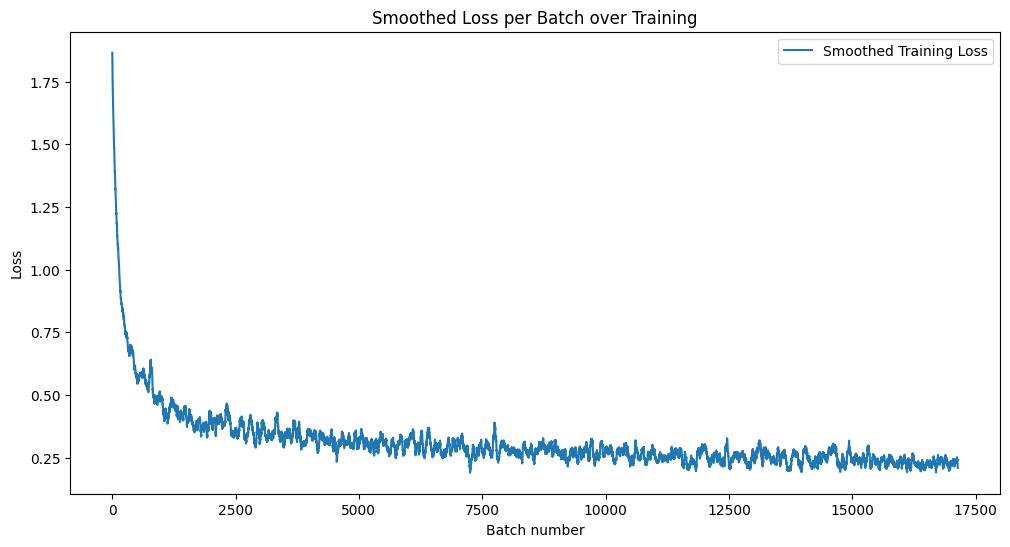

In [66]:
def running_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Choose a window size that's appropriate for your batch count
smoothed_losses = running_average(batch_train_losses, window_size=50)

plt.figure(figsize=(12, 6))
plt.plot(smoothed_losses, label='Smoothed Training Loss')
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.title('Smoothed Loss per Batch over Training')
plt.legend()
plt.show()


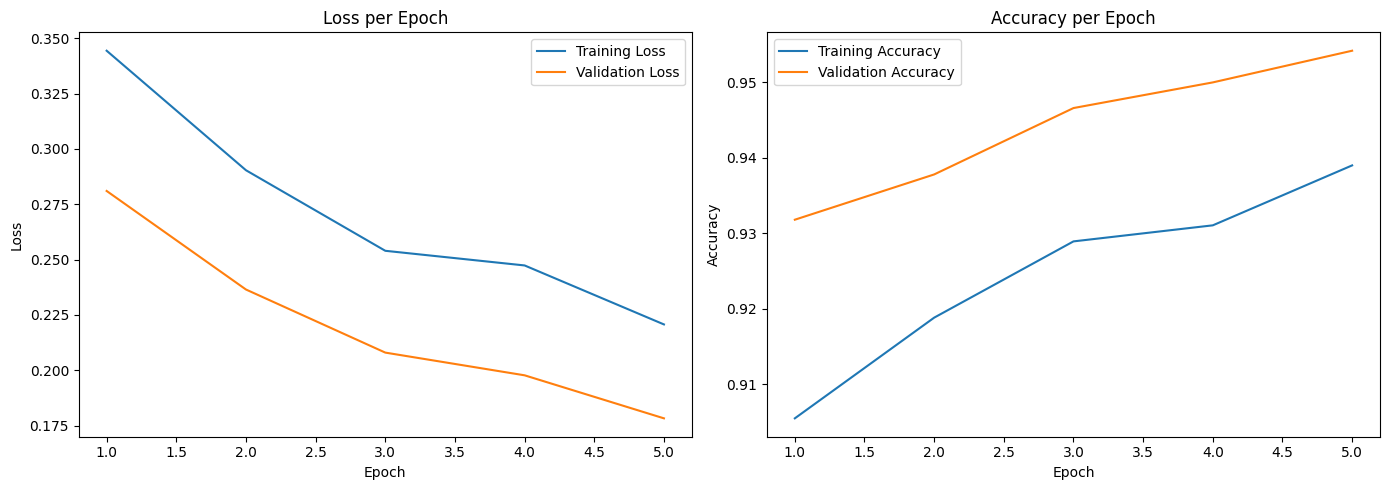

In [20]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
input_size = 784
hidden_size = 300
output_size = 10

W1 = np.random.randn(input_size, hidden_size) * np.sqrt(1. / input_size)
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1. / hidden_size)
b2 = np.zeros((1, output_size))

epochs = 5
learning_rate = 0.01
batch_size = 16

(X_train, y_train), (X_test, y_test) , cval = load_mnist()

y_train_one_hot = one_hot_encode(y_train)
y_test_one_hot = one_hot_encode(y_test)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [22]:
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []

# Number of runs with different initializations
n_runs = 3

for run in range(n_runs):
    # Reinitialize weights and biases here for each run
    W1 = np.random.randn(input_size, hidden_size) * np.sqrt(1. / input_size)
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1. / hidden_size)
    b2 = np.zeros((1, output_size))

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
      permutation = np.random.permutation(X_train.shape[0])
      X_train_shuffled = X_train[permutation]
      y_train_shuffled = y_train_one_hot[permutation]

      for i in range(0, X_train.shape[0], batch_size):
          X_batch = X_train_shuffled[i:i + batch_size]
          Y_batch = y_train_shuffled[i:i + batch_size]

          Z1, A1, Z2, A2 = forward_pass(X_batch, W1, b1, W2, b2)
          loss = compute_loss(A2, Y_batch)
          dW1, db1, dW2, db2 = backward_pass(X_batch, Y_batch, A1, A2, W2)
          W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

      _, _, _, A2_train = forward_pass(X_train, W1, b1, W2, b2)
      train_loss = compute_loss(A2_train, y_train_one_hot)
      train_accuracy = np.mean(np.argmax(A2_train, axis=1) == np.argmax(y_train_one_hot, axis=1))

      _, _, _, A2_val = forward_pass(X_test, W1, b1, W2, b2)
      val_loss = compute_loss(A2_val, y_test_one_hot)
      val_accuracy = np.mean(np.argmax(A2_val, axis=1) == np.argmax(y_test_one_hot, axis=1))

      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)

    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accuracies.append(train_accuracies)
    all_val_accuracies.append(val_accuracies)

In [23]:
# print(all_train_losses)
# print(all_val_losses)
# print(all_train_accuracies)
# print(all_val_accuracies)

In [24]:
all_train_losses = np.array(all_train_losses)
all_val_losses = np.array(all_val_losses)
all_train_accuracies = np.array(all_train_accuracies)
all_val_accuracies = np.array(all_val_accuracies)

In [25]:
train_loss_mean = all_train_losses.mean(axis=0)
train_loss_std = all_train_losses.std(axis=0)
val_loss_mean = all_val_losses.mean(axis=0)
val_loss_std = all_val_losses.std(axis=0)
train_accuracy_mean = all_train_accuracies.mean(axis=0)
train_accuracy_std = all_train_accuracies.std(axis=0)
val_accuracy_mean = all_val_accuracies.mean(axis=0)
val_accuracy_std = all_val_accuracies.std(axis=0)

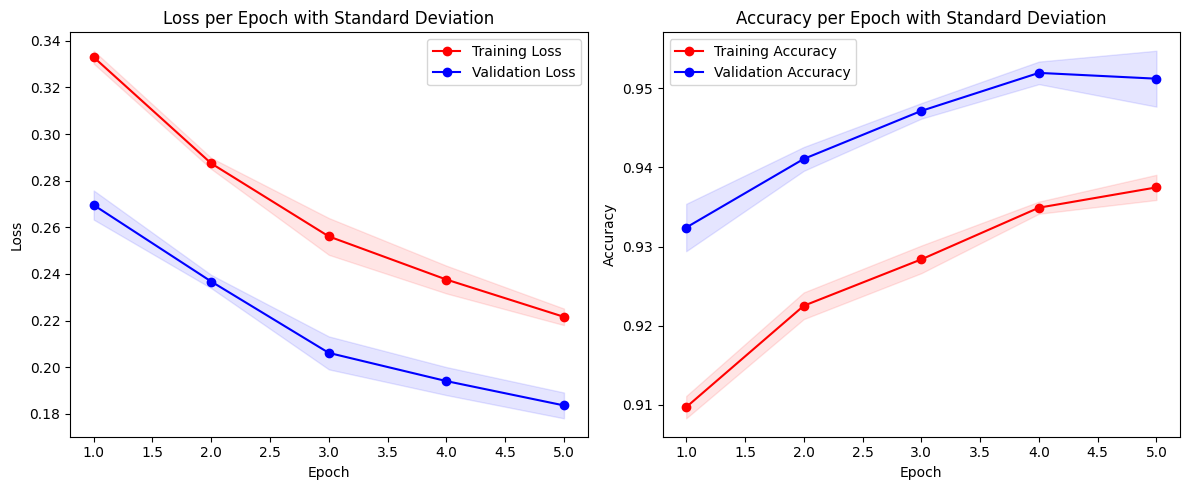

In [27]:
import matplotlib.pyplot as plt

epochs = range(1, 6)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# Plot the training loss with standard deviation
plt.fill_between(epochs,
                 [m - s for m, s in zip(train_loss_mean, train_loss_std)],
                 [m + s for m, s in zip(train_loss_mean, train_loss_std)],
                 color="red", alpha=0.1)
plt.plot(epochs, train_loss_mean, 'o-', color="red", label="Training Loss")

# Plot the validation loss with standard deviation
plt.fill_between(epochs,
                 [m - s for m, s in zip(val_loss_mean, val_loss_std)],
                 [m + s for m, s in zip(val_loss_mean, val_loss_std)],
                 color="blue", alpha=0.1)
plt.plot(epochs, val_loss_mean, 'o-', color="blue", label="Validation Loss")

plt.title("Loss per Epoch with Standard Deviation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# plt.show()


plt.subplot(1, 2, 2)
# Plot the training Accuracy with standard deviation
plt.fill_between(epochs,
                 [m - s for m, s in zip(train_accuracy_mean, train_accuracy_std)],
                 [m + s for m, s in zip(train_accuracy_mean, train_accuracy_std)],
                 color="red", alpha=0.1)
plt.plot(epochs, train_accuracy_mean, 'o-', color="red", label="Training Accuracy")

# Plot the validation Accuracy with standard deviation
plt.fill_between(epochs,
                 [m - s for m, s in zip(val_accuracy_mean, val_accuracy_std)],
                 [m + s for m, s in zip(val_accuracy_mean, val_accuracy_std)],
                 color="blue", alpha=0.1)
plt.plot(epochs, val_accuracy_mean, 'o-', color="blue", label="Validation Accuracy")

plt.title("Accuracy per Epoch with Standard Deviation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
print(train_loss_mean)
print(train_loss_std)
print(val_loss_mean)
print(val_loss_std)
print(train_accuracy_mean)
print(train_accuracy_std)
print(val_accuracy_mean)
print(val_accuracy_std)

[0.33294544 0.28739351 0.2560981  0.23760719 0.2216167 ]
[0.00277171 0.00237957 0.00789174 0.00595534 0.00354904]
[0.26956021 0.23676208 0.2061634  0.19407336 0.18364246]
[0.00624976 0.00284891 0.00707064 0.0060071  0.0055342 ]
[0.90971515 0.92252121 0.92838182 0.93490909 0.93747273]
[0.00140932 0.0016864  0.00174665 0.00076896 0.00159109]
[0.9324     0.94106667 0.94713333 0.95193333 0.9512    ]
[0.00299333 0.00150849 0.00098432 0.00142673 0.0035327 ]


In [56]:
input_size = 784
hidden_size = 300
output_size = 10

W1 = np.random.randn(input_size, hidden_size) * np.sqrt(1. / input_size)
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1. / hidden_size)
b2 = np.zeros((1, output_size))

epochs = 5
learning_rate = 0.01
batch_size = 16

(X_train, y_train), (X_test, y_test) , cval = load_mnist()

y_train_one_hot = one_hot_encode(y_train)
y_test_one_hot = one_hot_encode(y_test)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [57]:
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []

n_runs = 4

lrs = [0.001, 0.003, 0.01, 0.03]

for run in range(n_runs):
    W1 = np.random.randn(input_size, hidden_size) * np.sqrt(1. / input_size)
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1. / hidden_size)
    b2 = np.zeros((1, output_size))

    learning_rate = lrs[run]

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
      permutation = np.random.permutation(X_train.shape[0])
      X_train_shuffled = X_train[permutation]
      y_train_shuffled = y_train_one_hot[permutation]

      for i in range(0, X_train.shape[0], batch_size):
          X_batch = X_train_shuffled[i:i + batch_size]
          Y_batch = y_train_shuffled[i:i + batch_size]

          Z1, A1, Z2, A2 = forward_pass(X_batch, W1, b1, W2, b2)
          loss = compute_loss(A2, Y_batch)
          dW1, db1, dW2, db2 = backward_pass(X_batch, Y_batch, A1, A2, W2)
          W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

      _, _, _, A2_train = forward_pass(X_train, W1, b1, W2, b2)
      train_loss = compute_loss(A2_train, y_train_one_hot)
      train_accuracy = np.mean(np.argmax(A2_train, axis=1) == np.argmax(y_train_one_hot, axis=1))

      _, _, _, A2_val = forward_pass(X_test, W1, b1, W2, b2)
      val_loss = compute_loss(A2_val, y_test_one_hot)
      val_accuracy = np.mean(np.argmax(A2_val, axis=1) == np.argmax(y_test_one_hot, axis=1))

      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)

    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accuracies.append(train_accuracies)
    all_val_accuracies.append(val_accuracies)

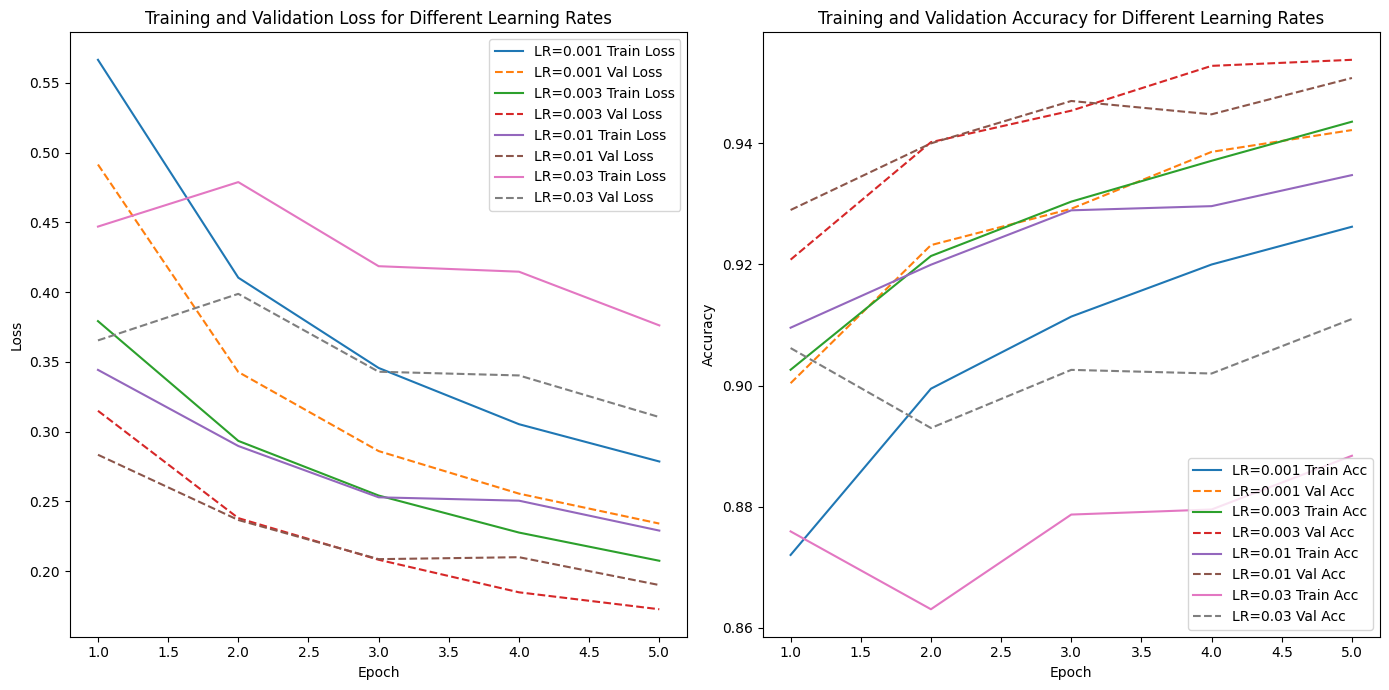

In [58]:
import numpy as np
import matplotlib.pyplot as plt

lrs = [0.001, 0.003, 0.01, 0.03]
epochs = np.arange(1, len(all_train_losses[0]) + 1)

# Plotting
plt.figure(figsize=(14, 7))

# Subplot for loss
plt.subplot(1, 2, 1)
for i, lr in enumerate(lrs):
    plt.plot(epochs, all_train_losses[i], label=f"LR={lr} Train Loss")
    plt.plot(epochs, all_val_losses[i], '--', label=f"LR={lr} Val Loss")

plt.title("Training and Validation Loss for Different Learning Rates")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Subplot for accuracy
plt.subplot(1, 2, 2)
for i, lr in enumerate(lrs):
    plt.plot(epochs, all_train_accuracies[i], label=f"LR={lr} Train Acc")
    plt.plot(epochs, all_val_accuracies[i], '--', label=f"LR={lr} Val Acc")

plt.title("Training and Validation Accuracy for Different Learning Rates")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [59]:
print(all_train_losses)
print(all_val_losses)
print(all_train_accuracies)
print(all_val_accuracies)


[[0.5665992382816847, 0.41040572727965435, 0.34568055930192004, 0.30536524781122754, 0.27862789715190867], [0.37925304433437707, 0.293398988530953, 0.254214886558126, 0.22767828154484462, 0.2074563858048956], [0.3443038774800189, 0.289730976913651, 0.25294503161488285, 0.25053736463691456, 0.22908522385760244], [0.4470339891852121, 0.4789280457282014, 0.4186333171133, 0.41469417761750227, 0.3761950029425077]]
[[0.49152618654138913, 0.34277982673500385, 0.28609077020678125, 0.2555844693638003, 0.23412625013581295], [0.3149642345908773, 0.23804049967857233, 0.20817917063556807, 0.18484116848470009, 0.1726988419723611], [0.28344803275008607, 0.23668784459077793, 0.20861606612861086, 0.2100197523575864, 0.19004628427539344], [0.36543478247632183, 0.39880711584864054, 0.34297459795638935, 0.34031889358325695, 0.31046579843560296]]
[[0.8720363636363636, 0.8994909090909091, 0.9114, 0.92, 0.9262363636363636], [0.9026181818181818, 0.9214, 0.9303818181818182, 0.9371272727272727, 0.94358181818181

In [33]:
input_size = 784
hidden_size = 300
output_size = 10

W1 = np.random.randn(input_size, hidden_size) * np.sqrt(1. / input_size)
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1. / hidden_size)
b2 = np.zeros((1, output_size))

epochs = 5
learning_rate = 0.003
batch_size = 16

(X_train, y_train), (X_test, y_test) , cval = load_mnist()

y_train_one_hot = one_hot_encode(y_train)
y_test_one_hot = one_hot_encode(y_test)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [34]:
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []

# Number of runs with different initializations
n_runs = 4

batch_sizes = [8, 16, 32, 64]

for run in range(n_runs):
    # Reinitialize weights and biases here for each run
    W1 = np.random.randn(input_size, hidden_size) * np.sqrt(1. / input_size)
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1. / hidden_size)
    b2 = np.zeros((1, output_size))

    batch_size = batch_sizes[run]

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
      permutation = np.random.permutation(X_train.shape[0])
      X_train_shuffled = X_train[permutation]
      y_train_shuffled = y_train_one_hot[permutation]

      for i in range(0, X_train.shape[0], batch_size):
          X_batch = X_train_shuffled[i:i + batch_size]
          Y_batch = y_train_shuffled[i:i + batch_size]

          Z1, A1, Z2, A2 = forward_pass(X_batch, W1, b1, W2, b2)
          loss = compute_loss(A2, Y_batch)
          dW1, db1, dW2, db2 = backward_pass(X_batch, Y_batch, A1, A2, W2)
          W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

      _, _, _, A2_train = forward_pass(X_train, W1, b1, W2, b2)
      train_loss = compute_loss(A2_train, y_train_one_hot)
      train_accuracy = np.mean(np.argmax(A2_train, axis=1) == np.argmax(y_train_one_hot, axis=1))

      _, _, _, A2_val = forward_pass(X_test, W1, b1, W2, b2)
      val_loss = compute_loss(A2_val, y_test_one_hot)
      val_accuracy = np.mean(np.argmax(A2_val, axis=1) == np.argmax(y_test_one_hot, axis=1))

      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)

    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accuracies.append(train_accuracies)
    all_val_accuracies.append(val_accuracies)

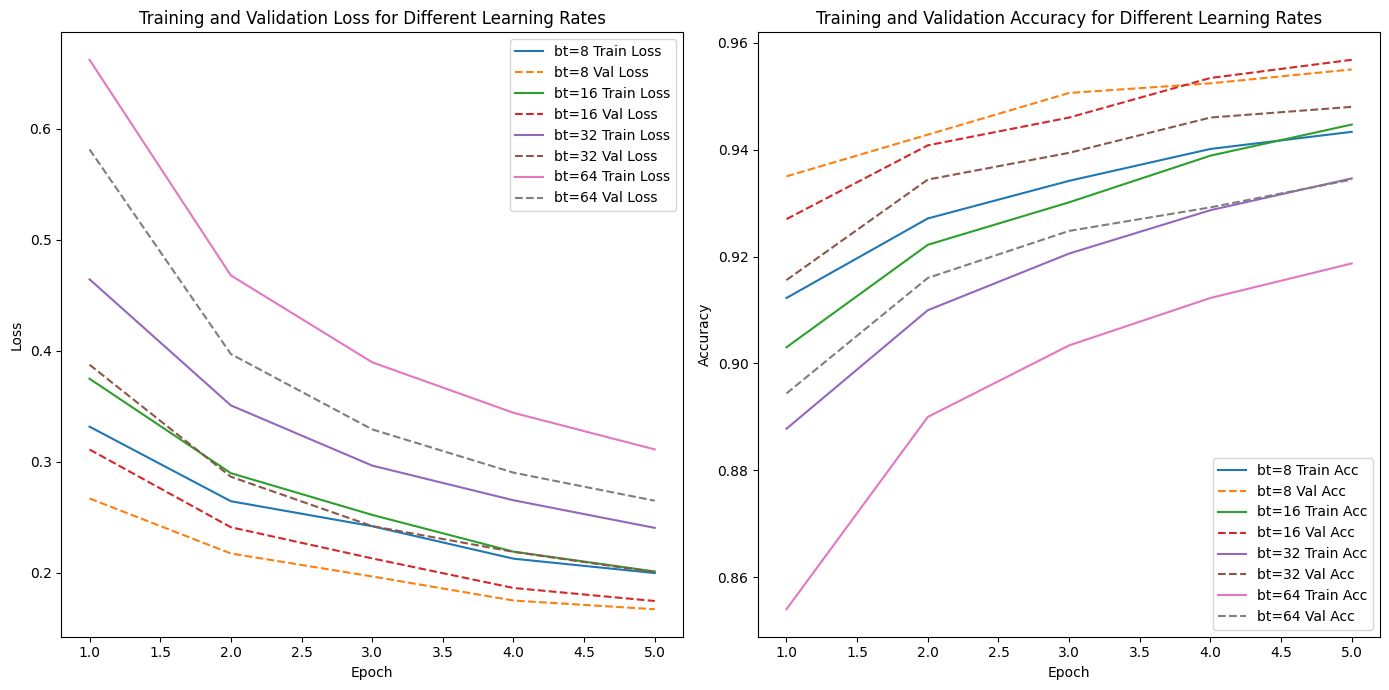

In [35]:
import numpy as np
import matplotlib.pyplot as plt

batch_sizes = [8, 16, 32, 64]
epochs = np.arange(1, len(all_train_losses[0]) + 1)

# Plotting
plt.figure(figsize=(14, 7))

# Subplot for loss
plt.subplot(1, 2, 1)
for i, bt in enumerate(batch_sizes):
    plt.plot(epochs, all_train_losses[i], label=f"bt={bt} Train Loss")
    plt.plot(epochs, all_val_losses[i], '--', label=f"bt={bt} Val Loss")

plt.title("Training and Validation Loss for Different Learning Rates")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Subplot for accuracy
plt.subplot(1, 2, 2)
for i, bt in enumerate(batch_sizes):
    plt.plot(epochs, all_train_accuracies[i], label=f"bt={bt} Train Acc")
    plt.plot(epochs, all_val_accuracies[i], '--', label=f"bt={bt} Val Acc")

plt.title("Training and Validation Accuracy for Different Learning Rates")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


# Best

In [36]:
input_size = 784
hidden_size = 300
output_size = 10

W1 = np.random.randn(input_size, hidden_size) * np.sqrt(1. / input_size)
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1. / hidden_size)
b2 = np.zeros((1, output_size))

epochs = 5
learning_rate = 0.003
batch_size = 16
#0.9440

# learning_rate = 0.003
# batch_size = 32
# 0.9360

(X_train, y_train), (X_test, y_test) , cval = load_mnist(final=True)

y_train_one_hot = one_hot_encode(y_train)
y_test_one_hot = one_hot_encode(y_test)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [37]:
for epoch in range(epochs):
    permutation = np.random.permutation(X_train.shape[0])
    X_train_shuffled = X_train[permutation]
    y_train_shuffled = y_train_one_hot[permutation]

    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train_shuffled[i:i + batch_size]
        Y_batch = y_train_shuffled[i:i + batch_size]

        Z1, A1, Z2, A2 = forward_pass(X_batch, W1, b1, W2, b2)
        loss = compute_loss(A2, Y_batch)

        dW1, db1, dW2, db2 = backward_pass(X_batch, Y_batch, A1, A2, W2)
        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

    _, _, _, A2_train = forward_pass(X_train, W1, b1, W2, b2)
    train_loss = compute_loss(A2_train, y_train_one_hot)
    train_accuracy = np.mean(np.argmax(A2_train, axis=1) == np.argmax(y_train_one_hot, axis=1))

    _, _, _, A2_val = forward_pass(X_test, W1, b1, W2, b2)
    val_loss = compute_loss(A2_val, y_test_one_hot)
    val_accuracy = np.mean(np.argmax(A2_val, axis=1) == np.argmax(y_test_one_hot, axis=1))


    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{epochs} - Loss: {train_loss:.4f} - Accuracy: {train_accuracy:.4f} - Val Loss: {val_loss:.4f} - Val Accuracy:  {val_accuracy:.4f}")

Epoch 1/5 - Loss: 0.3570 - Accuracy: 0.9082 - Val Loss: 0.3514 - Val Accuracy:  0.9101
Epoch 2/5 - Loss: 0.2761 - Accuracy: 0.9243 - Val Loss: 0.2752 - Val Accuracy:  0.9250
Epoch 3/5 - Loss: 0.2402 - Accuracy: 0.9346 - Val Loss: 0.2412 - Val Accuracy:  0.9340
Epoch 4/5 - Loss: 0.2133 - Accuracy: 0.9412 - Val Loss: 0.2183 - Val Accuracy:  0.9389
Epoch 5/5 - Loss: 0.1954 - Accuracy: 0.9476 - Val Loss: 0.2043 - Val Accuracy:  0.9428


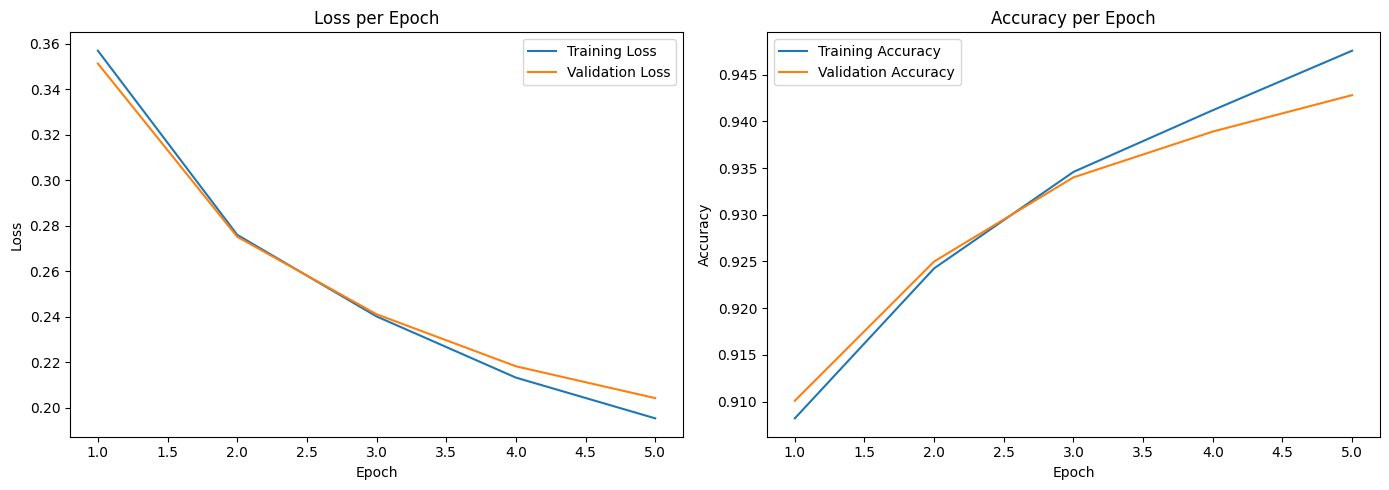

In [38]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()